Some examples of manipulation of transition matrices

In [1]:
import numpy as np
import seaborn as sns
from indemmar import plot_and_legend
from pathlib import Path
from matplotlib import pyplot as plt
import numpy.linalg as la
import moments
import scipy
plt.rc('font', family='serif', size=16)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.style.use('seaborn')

Using values from compute_Q_from_scratch.py



In [2]:
s = 0.0

no = 2   # sample size
j = 0    # jackknife
k = 0     # max number of resamples (maximum selection failures)
N = 100
Ns = round(N*s)

data_store = Path.cwd() / Path("../data")

try:
    QT = np.loadtxt(data_store / Path(f"q_mat_{N}_{Ns}_{no}_{k}_{j}.txt"))
except OSError:
    print("Q matrix",data_store / Path(f"q_mat_{N}_{Ns}_{no}_{k}_{j}.txt"), "was likely not found." 
          " Check path or run compute_Q_from_scratch.py wioth correct parameters" )
    
    

Test whether the columns of Q (and rows to QT) sum to 1. 

In [3]:
QT.sum(axis=1)-1

array([0., 0., 0.])

### Infinite-sites model

To compute the equilibrium distribution in the infinite-sites model, we can simply solve the linear equation 

In [4]:
mu = 1e-8
predicted_pi = 2*mu*N

#this code was copied and modified from Spectra.py   
I = np.eye(no - 1)
z = np.zeros(no - 1)
z[0] = (no) * mu
pi = la.solve((QT[1:-1, 1:-1] - I).T, -z)

print("computed: pi", pi)
print("Expectation 2 N mu", predicted_pi)


computed: pi [2.e-06]
Expectation 2 N mu 2e-06


### Finite sites model

Repeat the calculation under the finite sites model


In [5]:
# Load the reversible mutation matrix from moments
sparse_mutation = moments.LinearSystem_1D.calcB_FB(no+1,mu,mu)

# Add the identity matrix to obtain the recursion in the standard format
transition_mutation = sparse_mutation.toarray()+np.eye(no+1)


The SD matrix applies selection and drift first, to generate the unmutated alleles that would have been inherited by the offspring without mutation. The the mutation matrix acts on these trasmitted gametes.  

In [6]:
MQT = np.dot(transition_mutation, QT.transpose())

In [7]:

MQT


array([[9.9999998e-01, 5.0000098e-03, 0.0000000e+00],
       [2.0000000e-08, 9.8999998e-01, 2.0000000e-08],
       [0.0000000e+00, 5.0000098e-03, 9.9999998e-01]])

In [8]:
eigs = np.linalg.eig((MQT - I))

#eig should be normalized to sum to 1
eigenvector = eigs[1][:,-1]/eigs[1][:,-1].sum()

print("eigenvector corresponding to eigenvalue", eigs[0][-1]," is\n", eigenvector) 



eigenvector corresponding to eigenvalue 0.9899999604000002  is
 [ 7.35434740e+15 -1.47086948e+16  7.35434740e+15]


Note the modest difference with the infinite-sites model. There are modest differences between the two models. For example the creation of new heterozygotes in the finite sites model is slightly lower due to the fact that mutation only creates heterozygotes from fixed sites, of which there are $1-\pi$, whereas the infinite-sites model assumes a fixed rate of mutation.     

 ### Modelling a bottleneck
 
To model a bottleneck, we will load two matrix, corresponding to large ($NL=100 000$) and bottlenecked ($NB=100$) population sizes. We will choose $s = 0.01$ so that $NBs = 1$
 
 

In [9]:
s = 0.01

no = 50   # sample size
j = 7    # jackknife
k = 3     # max number of resamples (maximum selection failures)
NB = 100   # A small population for this small example
NBs = round(NB*s) #
NL = 10000
NLs = round(NL*s)



data_store = Path.cwd() / Path("../data")

try:
    QT_bottle = np.loadtxt(data_store / Path(f"q_mat_{NB}_{NBs}_{no}_{k}_{j}.txt"))
except OSError:
    print("Q matrix",data_store / Path(f"q_mat_{NB}_{NBs}_{no}_{k}_{j}.txt"), "was likely not found." 
          " Check path or run compute_Q_from_scratch.py wioth correct parameters" )
    
try:
    QT_large = np.loadtxt(data_store / Path(f"q_mat_{NL}_{NLs}_{no}_{k}_{j}.txt"))
except OSError:
    print("Q matrix",data_store / Path(f"q_mat_{NL}_{NLs}_{no}_{k}_{j}.txt"), "was likely not found." 
          " Check path or run compute_Q_from_scratch.py wioth correct parameters" )

Check that the matrices sum to one



In [10]:
QT_bottle.sum(axis=1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999997,
       1.00000006, 0.99999997, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.00000001])

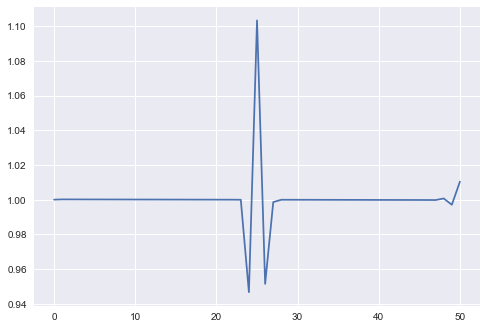

In [11]:
plt.plot(QT_large.sum(axis=1))

This lack of normalization looks scary, but it is fine as long as the SFS is smooth around f=0.5. This is discussed in issue #6. 

In [14]:
# Equilibrium spectrum for large population, infinite-sites model

I = np.eye(no - 1)
z_short = np.zeros(no - 1)
z_short[0] = (no) * mu
sfs_large = la.solve((QT_large[1:-1, 1:-1] - I).T, -z_short)
sfs_bottle = la.solve((QT_bottle[1:-1, 1:-1] - I).T, -z_short)

Text(0, 0.5, 'proportion of sites')

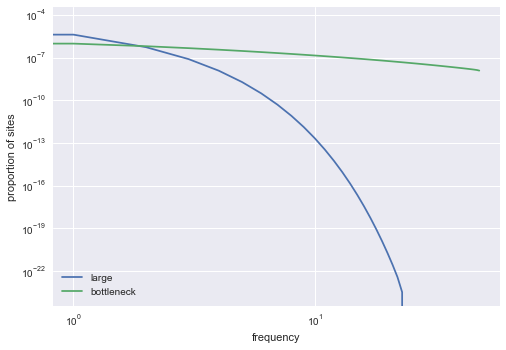

In [15]:
plt.loglog(sfs_large,label = 'large')
plt.loglog(sfs_bottle,label = 'bottleneck')
plt.legend(loc = "lower left")
plt.xlabel('frequency')
plt.ylabel('proportion of sites')

Compute out-of-equilibrium SFS

In [33]:
n_generations = 1000
list_sfs_WF = [np.hstack((sfs_large,[0]))]

z = np.zeros(no)
z[0] = (no) * mu
for _ in range(n_generations):
    list_sfs_WF.append(np.dot(QT_bottle.transpose()[1:,1:],list_sfs_WF[-1]) + z)

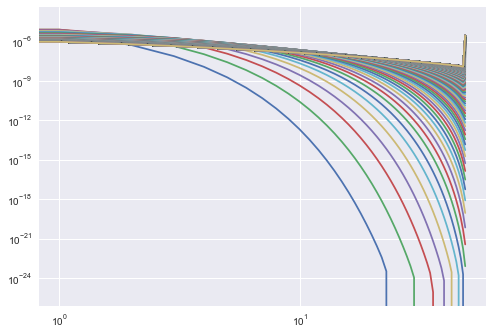

In [17]:
[plt.loglog(sfs) for sfs in list_sfs_WF];

Do the same using the moments transition matrix! 

To get the equilibrium value, note that these are instantaneous rates, so that we want the limit

$$\lim_{k\rightarrow \infty}(I+ (D+S)/k)^k = e^{D+S}$$ 



In [18]:
h = 0.5
D_matrix = (1/2./NB) * moments.LinearSystem_1D.calcD(no+1).toarray()
S_matrix = s *h* moments.LinearSystem_1D.calcS(no+1, moments.Jackknife.calcJK13(no))

moment_matrix = scipy.linalg.expm(D_matrix+S_matrix.toarray())



We'll assume here that mutations in both models are introduced once per generation, to compare the differences in drift and selection modelling.

In [19]:


I = np.eye(no-1)

moment_smallpop_equil = la.solve((moment_matrix[1:-1, 1:-1] - I), -z_short)
WF_smallpop_equil = la.solve((QT_bottle[1:-1, 1:-1] - I).T, -z_short)

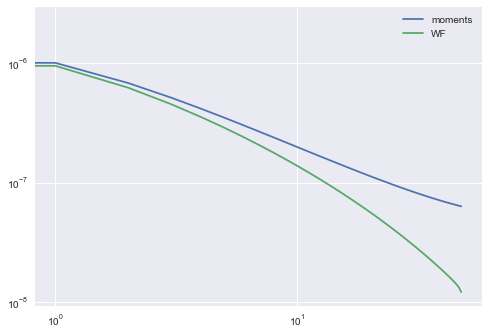

In [20]:
plt.loglog(moment_smallpop_equil,label = "moments")
plt.loglog(WF_smallpop_equil,label = 'WF')
plt.legend(loc = "upper right")

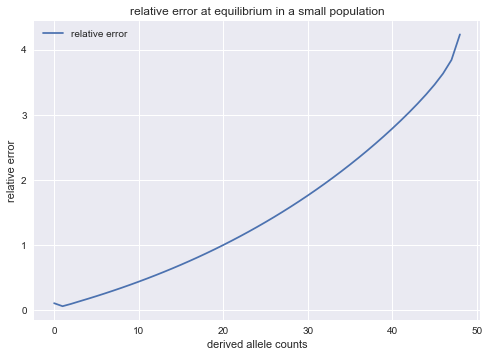

In [21]:
plt.plot((moment_smallpop_equil - WF_smallpop_equil)/WF_smallpop_equil ,label = "relative error")
plt.title("relative error at equilibrium in a small population")


plt.xlabel("derived allele counts")
plt.ylabel("relative error")
plt.legend(loc = "upper left")

In [22]:
n_generations = 1000
list_sfs_moments = [list_sfs_WF[0]]


for _ in range(n_generations):
    list_sfs_moments.append(np.dot(moment_matrix[1:,1:],list_sfs_moments[-1]) + z)

Text(0, 0.5, 'frequency')

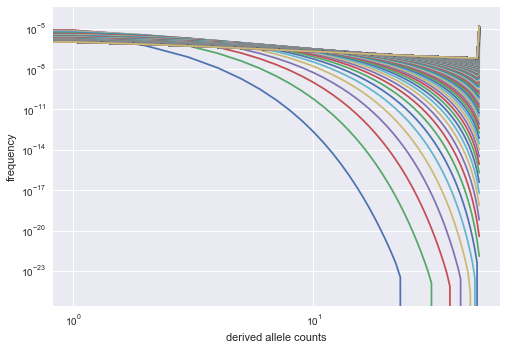

In [23]:
[plt.loglog(sfs) for sfs in list_sfs_moments];

plt.xlabel("derived allele counts")
plt.ylabel("frequency")



Text(0, 0.5, 'frequency')

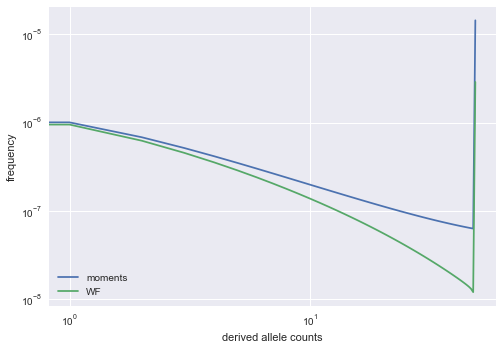

In [24]:
compare_generation = 999

plt.loglog(list_sfs_moments[compare_generation],label = "moments")
plt.loglog(list_sfs_WF[compare_generation],label = "WF")
plt.legend(loc="lower left")

plt.xlabel("derived allele counts")
plt.ylabel("frequency")


relative error in (n-1)-tons

In [25]:
array_moments = np.array(list_sfs_moments)
array_WF = np.array(list_sfs_WF)

Text(0.5, 1.0, 'fixation rate following a bottleneck')

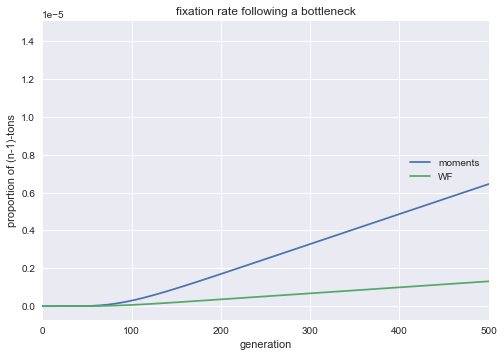

In [26]:
frequency_bin_to_plot = -1

plt.plot(array_moments[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")
plt.legend(loc="center right")
plt.xlim((0,500))

plt.title("fixation rate following a bottleneck")


(0.0, 200.0)

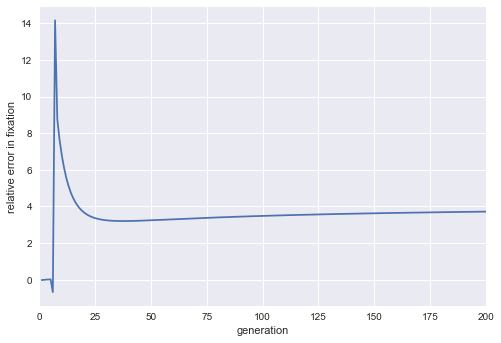

In [27]:
frequency_bin_to_plot = -1
plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])/array_WF[:,frequency_bin_to_plot], label = "moments")
plt.xlabel("generation")
plt.ylabel("relative error in fixation")
plt.xlim((0,200))

(0.0, 200.0)

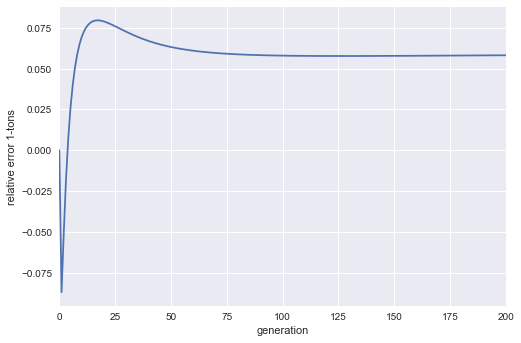

In [28]:
frequency_bin_to_plot = 1
plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])/array_WF[:,frequency_bin_to_plot], label = "moments")
plt.xlabel("generation")
plt.ylabel("relative error 1-tons")
plt.xlim((0,200))

Repeat for neutrality

In [29]:
s = 0

no = 50   # sample size
j = 7    # jackknife
k = 3     # max number of resamples (maximum selection failures)
NB = 100   # A small population for this small example
NBs = round(NB*s) #
NL = 10000
NLs = round(NL*s)



data_store = Path.cwd() / Path("../data")

try:
    QT_bottle_neutral = np.loadtxt(data_store / Path(f"q_mat_{NB}_.1_{no}_{k}_{j}.txt"))
except OSError:
    print("Q matrix",data_store / Path(f"q_mat_{NB}_.1_{no}_{k}_{j}.txt"), "was likely not found." 
          " Check path or run compute_Q_from_scratch.py wioth correct parameters" )
    
try:
    QT_large_neutral = np.loadtxt(data_store / Path(f"q_mat_{NL}_{NLs}_{no}_{k}_{j}.txt"))
except OSError:
    print("Q matrix",data_store / Path(f"q_mat_{NL}_{NLs}_{no}_{k}_{j}.txt"), "was likely not found." 
          " Check path or run compute_Q_from_scratch.py wioth correct parameters" )

In [30]:
# Equilibrium spectrum for large population, infinite-sites model

I = np.eye(no - 1)


sfs_large_neutral = la.solve((QT_large_neutral[1:-1, 1:-1] - I).T, -z_short)
sfs_bottle_neutral = la.solve((QT_bottle_neutral[1:-1, 1:-1] - I).T, -z_short)

Text(0, 0.5, 'proportion of sites')

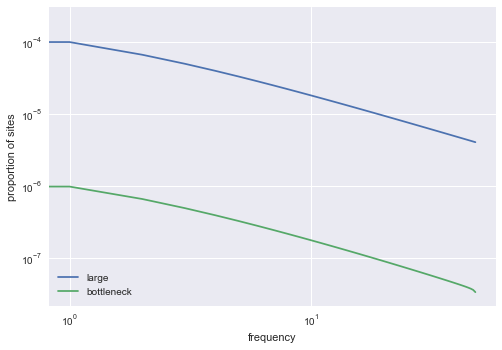

In [34]:
plt.loglog(sfs_large_neutral,label = 'large')
plt.loglog(sfs_bottle_neutral,label = 'bottleneck')
plt.legend(loc = "lower left")
plt.xlabel('frequency')
plt.ylabel('proportion of sites')

In [35]:
n_generations = 1000
list_sfs_WF_neutral = [np.hstack((sfs_large_neutral,[0]))]  # Consider fixed mutations as well as polymorphisms 

for _ in range(n_generations):
    list_sfs_WF_neutral.append(np.dot(QT_bottle_neutral.transpose()[1:,1:],list_sfs_WF_neutral[-1]) + z)

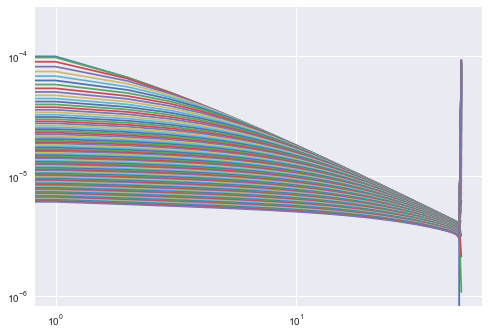

In [36]:
[plt.loglog(sfs) for sfs in list_sfs_WF_neutral[:100]];

In [37]:
moment_matrix_neutral = scipy.linalg.expm(D_matrix)



In [38]:
n_generations = 1000
list_sfs_moments_neutral = [list_sfs_WF_neutral[0]]

for _ in range(n_generations):
    list_sfs_moments_neutral.append(np.dot(moment_matrix_neutral[1:,1:],list_sfs_moments_neutral[-1]) + z)

In [39]:
array_moments_neutral = np.array(list_sfs_moments_neutral)
array_WF_neutral = np.array(list_sfs_WF_neutral)

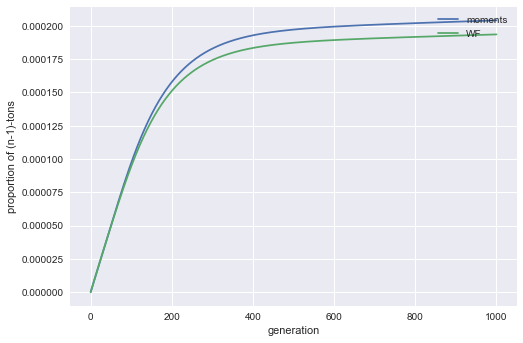

In [40]:
frequency_bin_to_plot = -1

plt.plot(array_moments_neutral[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF_neutral[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")

plt.legend(loc = "upper right")


(0.0, 200.0)

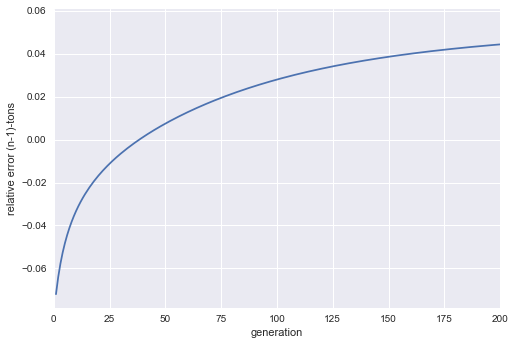

In [41]:
frequency_bin_to_plot = -1
plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])/array_WF_neutral[:,frequency_bin_to_plot], label = "moments")
plt.xlabel("generation")
plt.ylabel("relative error (n-1)-tons")
plt.xlim((0,200))


Text(0, 0.5, 'proportion of (n-1)-tons')

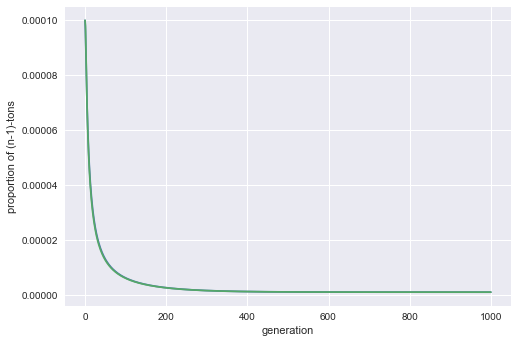

In [42]:
frequency_bin_to_plot = 1

plt.plot(array_moments_neutral[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF_neutral[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")

(0.0, 200.0)

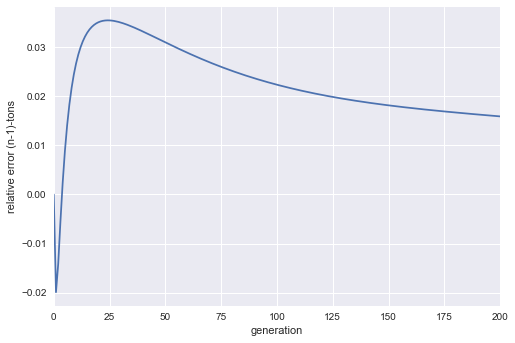

In [43]:
frequency_bin_to_plot = 1
plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])/array_WF_neutral[:,frequency_bin_to_plot], label = "moments")
plt.xlabel("generation")
plt.ylabel("relative error (n-1)-tons")
plt.xlim((0,200))

Text(0.5, 0, 'Generation after bottleneck')

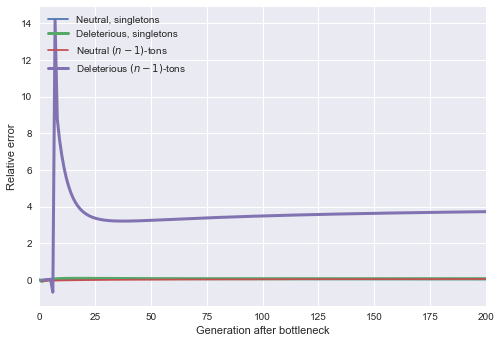

In [44]:
frequency_bin_to_plot = 1

plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])
         /array_WF_neutral[:,frequency_bin_to_plot], label="Neutral, singletons")

plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])
         /array_WF[:,frequency_bin_to_plot], lw=3, label="Deleterious, singletons")

frequency_bin_to_plot = -1

plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])
         /array_WF_neutral[:,frequency_bin_to_plot], label="Neutral $(n-1)$-tons")

plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])/
         array_WF[:,frequency_bin_to_plot], lw=3, label="Deleterious $(n-1)$-tons")


plt.xlim((0,200))
plt.legend(loc="upper left")
plt.ylabel("Relative error")
plt.xlabel("Generation after bottleneck")

There is something happening extraordinarily fast, specifically for the $n-1$-tons. LEt us look at this in case it is just a bug. 

Text(0.5, 0, 'Generation after bottleneck')

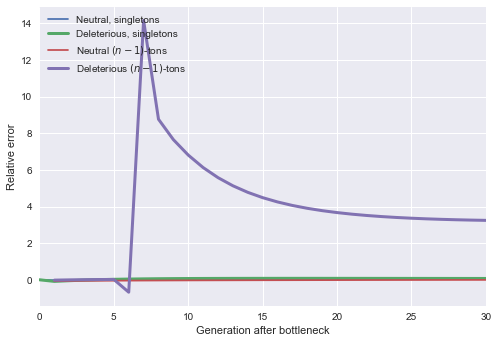

In [45]:
frequency_bin_to_plot = 1

plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])
         /array_WF_neutral[:,frequency_bin_to_plot], label="Neutral, singletons")

plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])
         /array_WF[:,frequency_bin_to_plot], lw=3, label="Deleterious, singletons")

frequency_bin_to_plot = -1

plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])
         /array_WF_neutral[:,frequency_bin_to_plot], label="Neutral $(n-1)$-tons")

plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])/
         array_WF[:,frequency_bin_to_plot], lw=3, label="Deleterious $(n-1)$-tons")


plt.xlim((0,30))
plt.legend(loc="upper left")
plt.ylabel("Relative error")
plt.xlabel("Generation after bottleneck")

(0.0, 500.0)

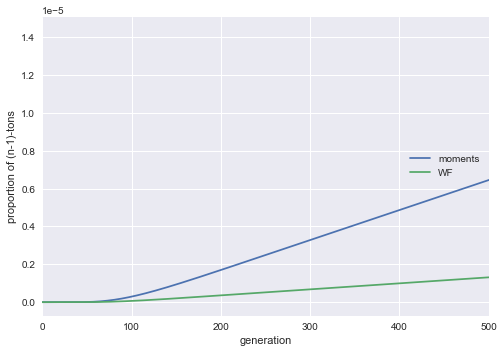

In [46]:
frequency_bin_to_plot = -1

plt.plot(array_moments[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")
plt.legend(loc="center right")
plt.xlim((0,500))




So if there is not problem, what is going on is that the rate of fixation is higher, overall, and more specifically that the fixation starts quite a bit earlier. 

(0.0, 200.0)

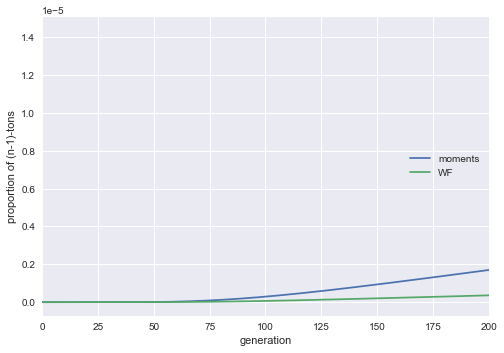

In [47]:
frequency_bin_to_plot = -1

plt.plot(array_moments[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")
plt.legend(loc="center right")
plt.xlim((0,200))

